# Semi-parametric Inference using Machine Learning
#### by Danial Syed

## Part 1: Simulation Study

### 1) Initialization 

In [1]:
rm(list=ls())

library(DoubleML)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(data.table)
library(mvtnorm)
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

### Machine Learning Estimation function for $g_{0}$ and $m_{0}$

In [2]:
# Random Forest Estimation Function
est_forest <- function(obj_dml_data) {
    
    learner <- lrn("regr.ranger", num.trees=100, mtry=n_vars, min.node.size=2, max.depth=5)
    ml_m <- learner$clone()
    ml_g <- learner$clone()
    
    obj_dml_plr  <- DoubleMLPLR$new(obj_dml_data, ml_g, ml_m)
    
    obj_dml_plr$fit()
    theta = obj_dml_plr$coef
    return(theta)
}

# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    ml_g <- learner$clone()
    ml_m <- learner$clone()

    obj_dml_plr  <- DoubleMLPLR$new(obj_dml_data, ml_g, ml_m)

    obj_dml_plr$fit()
    theta = obj_dml_plr$coef
    return(theta)
}

# Regression Tree Estimation
est_rt   <- function(obj_dml_data){

    learner <- lrn("regr.rpart")
    ml_g <- learner$clone()
    ml_m <- learner$clone()
    
    obj_dml_plr = DoubleMLPLR$new(obj_dml_data, ml_g, ml_m)

    param_grid = list(
      "ml_g" = paradox::ParamSet$new(list(
            paradox::ParamDbl$new("cp", lower = 0.01, upper = 0.02),
            paradox::ParamInt$new("minsplit", lower = 1, upper = 2))),
      "ml_m" = paradox::ParamSet$new(list(
            paradox::ParamDbl$new("cp", lower = 0.01, upper = 0.02),
            paradox::ParamInt$new("minsplit", lower = 1, upper = 2))))

    # minimum requirements for tune_settings
    tune_settings = list(
    terminator = mlr3tuning::trm("evals", n_evals = 5),
    algorithm = mlr3tuning::tnr("grid_search", resolution = 5))
    obj_dml_plr$tune(param_set = param_grid, tune_settings = tune_settings)
    obj_dml_plr$fit()
    
    theta = obj_dml_plr$coef
    return(theta)

}


### Custom Data Generating Process

In [82]:
dgp <- function(rho, n_vars, sample_size, alpha) {
    
    corr_matrix <- matrix(NA, n_vars, n_vars)

    for (i in 1:n_vars) {
        for (j in 1:n_vars) {
        corr_matrix[i, j] = rho^(abs(i - j))
        }
    }
    
    x = rmvnorm(n = sample_size, mean = rep(0,n_vars), sigma = corr_matrix)
    
    #g_0_X = as.matrix(2.5*(cos(x[,1])^3) + 0.5*(sin(x[,3]))/(1+sin(x[,3])))
    #g_0_X = as.matrix(2.5*(cos(x[,1])^3) + 0.5*(sin(x[,3])))
    g_0_X = as.matrix(sin(x[,1]) + 1.5*(exp(-10*(x[,3]^2))))
    
    #m_0_X = as.matrix(0.5*(sin(x[,1])^3) + 2.5*(cos(x[,3]))/(1+cos(x[,3])))
    #m_0_X = as.matrix(0.5*(sin(x[,1])^3) + 2.5*(cos(x[,3])))
    m_0_X = as.matrix(6*(1-cos(pi*x[,1]/4)) + 2.5*x[,3])
    
    eps = rnorm(sample_size, 0, 1) 
    ups = rnorm(sample_size, 0, 1) 
    
    d   = m_0_X + ups
    y   = alpha*d + g_0_X + eps
    
    colnames(x) = paste0("x", 1:n_vars)
    colnames(y) = "y"
    colnames(d) = "d"
    
    data = data.frame(x, y, d)
    return(data)    
}

### Simulation Function

In [3]:
sim_function <- function(data){
    
    obj_dml_data <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    theta_lasso  <- est_lasso(obj_dml_data)
    theta_forest <- est_forest(obj_dml_data)  
    theta_rt     <- est_rt(obj_dml_data)
    
    theta <- cbind(theta_lasso, theta_forest, theta_rt)
    
    return(theta)
}

### Parameter Setup

In [4]:
### Fixed Design Parameters
n_rep  = 100
n_vars = 150
alpha  = 3
#rho   = 0.7

## Varying the sample size from 30 to 100
sample_size <- seq(30, 200, by = 5)
sim         <- length(sample_size)

# Number of iterations to perform over each sample size
bias_matrix <- matrix(NA, ncol = 3, nrow = sim)
var_matrix  <- matrix(NA, ncol = 3, nrow = sim)
mse_matrix  <- matrix(NA, ncol = 3, nrow = sim)

### Naïve Estimate with equal sample split

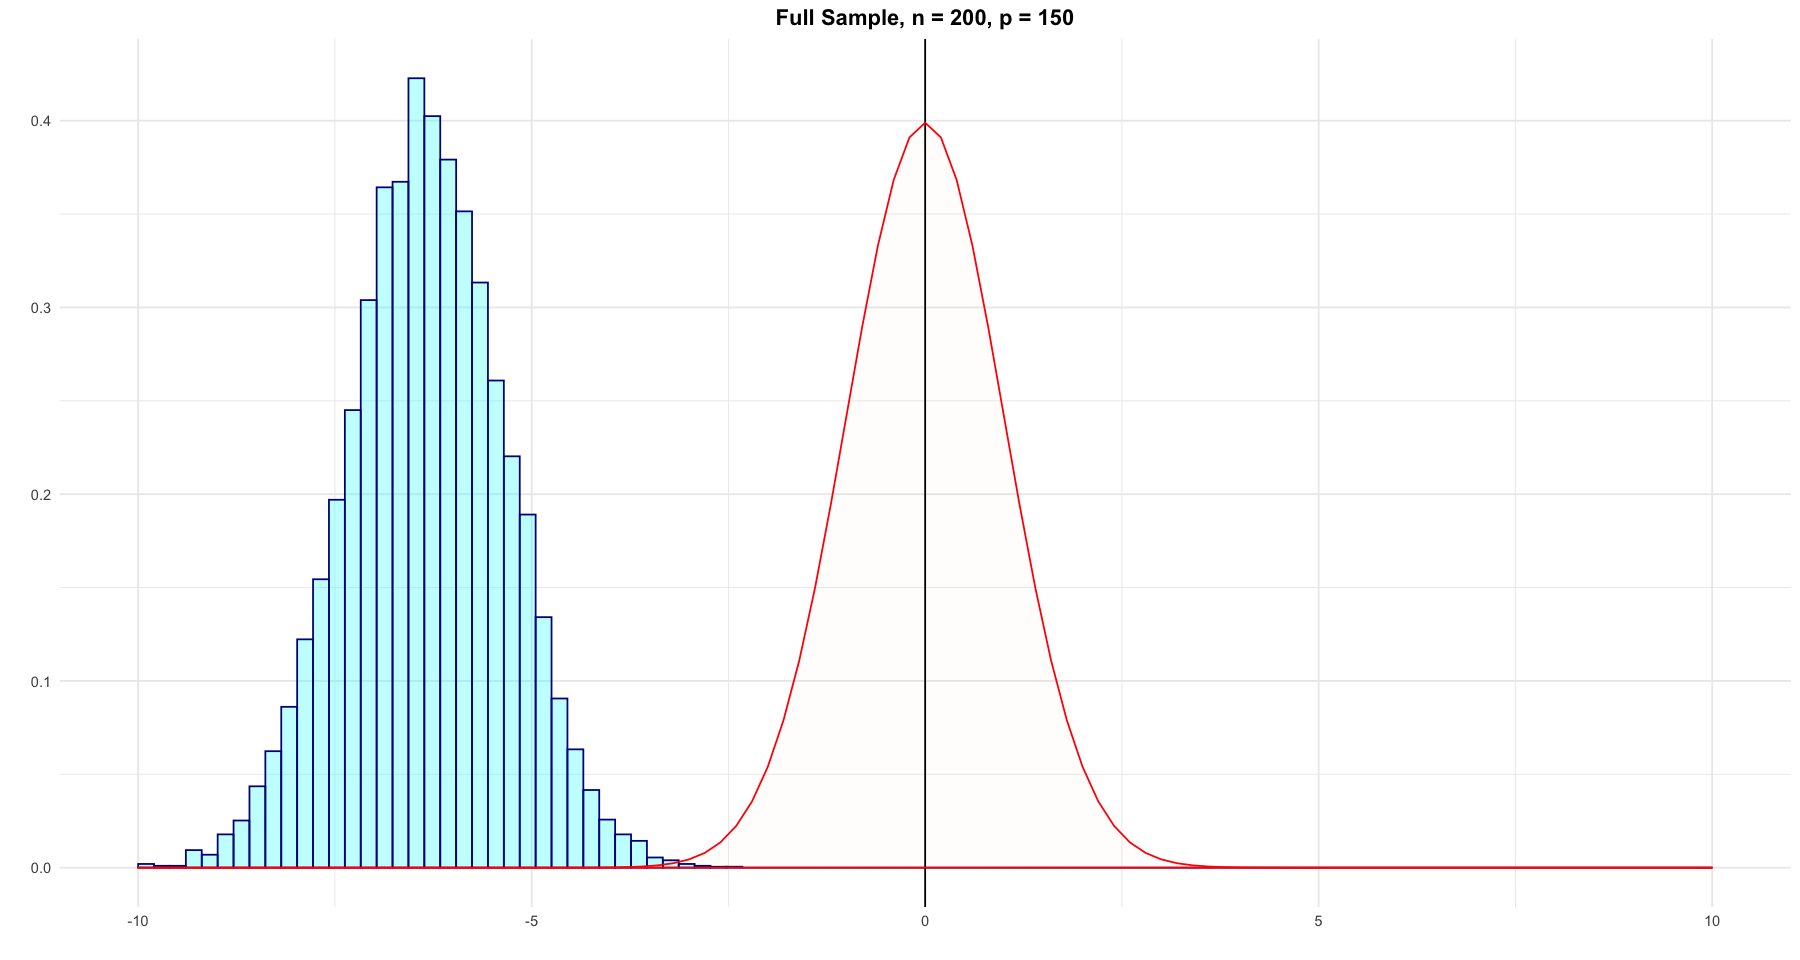

In [122]:
n_rep  = 10000
n_vars = 150
alpha  = 1
#rho   = 0.7

theta_hat_naive <- rep(NA, n_rep)
n_obs = 200

for (i in 1:n_rep) {
    set.seed(i)
    data = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type="data.frame") 
    task_g <- TaskRegr$new(id = "data", backend = data, target = "y")
    learner <- lrn("regr.ranger", num.trees=100, mtry=n_vars, min.node.size=2, max.depth=5)
    
    train_set <- sample(task_g$nrow, 0.5 * task_g$nrow)
    test_set  <- setdiff(seq_len(task_g$nrow), train_set)

    # train the model
    learner$train(task_g, row_ids = train_set)

    # predict data
    g_hat <- learner$predict(task_g, row_ids = test_set)
    theta_hat_naive[i] <- (mean(data[test_set,]$d*(data[test_set,]$y - g_hat$response)))/mean(data[test_set,]$d^2)

}

df_naive = data.frame(theta_hat_naive = theta_hat_naive - alpha)
sd_naive = sd(theta_hat_naive)

df_naive_std = data.frame("theta_hat_naive" = df_naive$theta_hat_naive/sd_naive)

g_naive_std = ggplot(df_naive_std, aes(x = theta_hat_naive)) +
            geom_histogram(aes(y=..density..), bins = 100, fill = "cyan", alpha = 0.3, color = "dark blue") +
            geom_vline(aes(xintercept = 0), col = "black") +
            xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() +       
            stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
            ggtitle(paste0("Full Sample, n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))

g_naive_std

### 5) Monte Carlo Simulation with Parallelization

In [68]:
set.seed(70)
RNGkind("L'Ecuyer-CMRG")

for (j in 1:sim) {
    
    boot_fx <- function(iteration) {
        
        data = make_plr_CCDDHNR2018(alpha=alpha, n_obs=sample_size[j], dim_x=n_vars, return_type="data.frame") # use default DGP provided in packages (chernozhukov 2018)
        #data = dgp(rho, n_vars, sample_size[j], alpha) # use customised data from block 2b)
        output.matrix <- sim_function(data)
        return(output.matrix) 
    }
    
    combined_matrix <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    matrix_         <- do.call(rbind, combined_matrix)
    
    bias_matrix[j,1]  <- (mean(matrix_[,1]) - alpha)^2
    bias_matrix[j,2]  <- (mean(matrix_[,2]) - alpha)^2
    bias_matrix[j,3]  <- (mean(matrix_[,3]) - alpha)^2
    
    var_matrix[j,1]  <- (1/(sample_size[j]-1))*sum(((matrix_[,1] - mean(matrix_[,1]))^2))
    var_matrix[j,2]  <- (1/(sample_size[j]-1))*sum(((matrix_[,2] - mean(matrix_[,2]))^2))
    var_matrix[j,3]  <- (1/(sample_size[j]-1))*sum(((matrix_[,3] - mean(matrix_[,3]))^2))  
    
    mse_matrix[j,1]  <- mean((matrix_[,1] - alpha)^2) 
    mse_matrix[j,2]  <- mean((matrix_[,2] - alpha)^2) 
    mse_matrix[j,3]  <- mean((matrix_[,3] - alpha)^2) 
    
}


### Monte Carlo Simulation without parallelization

In [ ]:
matrix_ <- matrix(NA, ncol = 3, nrow = n_rep)

for (j in 1:sim) {   
    for (i in 1:n_rep) {
        set.seed(i)
        data = make_plr_CCDDHNR2018(alpha=alpha, n_obs=sample_size[j], dim_x=n_vars, return_type="data.frame")  
        invisible(capture.output(suppressWarnings(matrix_[i,] <- sim_function(data))))
    } 
    
    bias_matrix[j,1]  <- (mean(matrix_[,1]) - alpha)^2
    bias_matrix[j,2]  <- (mean(matrix_[,2]) - alpha)^2
    bias_matrix[j,3]  <- (mean(matrix_[,3]) - alpha)^2
    
    var_matrix[j,1]  <- (1/(sample_size[j]-1))*sum(((matrix_[,1] - mean(matrix_[,1]))^2))
    var_matrix[j,2]  <- (1/(sample_size[j]-1))*sum(((matrix_[,2] - mean(matrix_[,2]))^2))
    var_matrix[j,3]  <- (1/(sample_size[j]-1))*sum(((matrix_[,3] - mean(matrix_[,3]))^2))
    
    mse_matrix[j,1]  <- mean((matrix_[,1] - alpha)^2) 
    mse_matrix[j,2]  <- mean((matrix_[,2] - alpha)^2) 
    mse_matrix[j,3]  <- mean((matrix_[,3] - alpha)^2) 
}



### Showing the Results

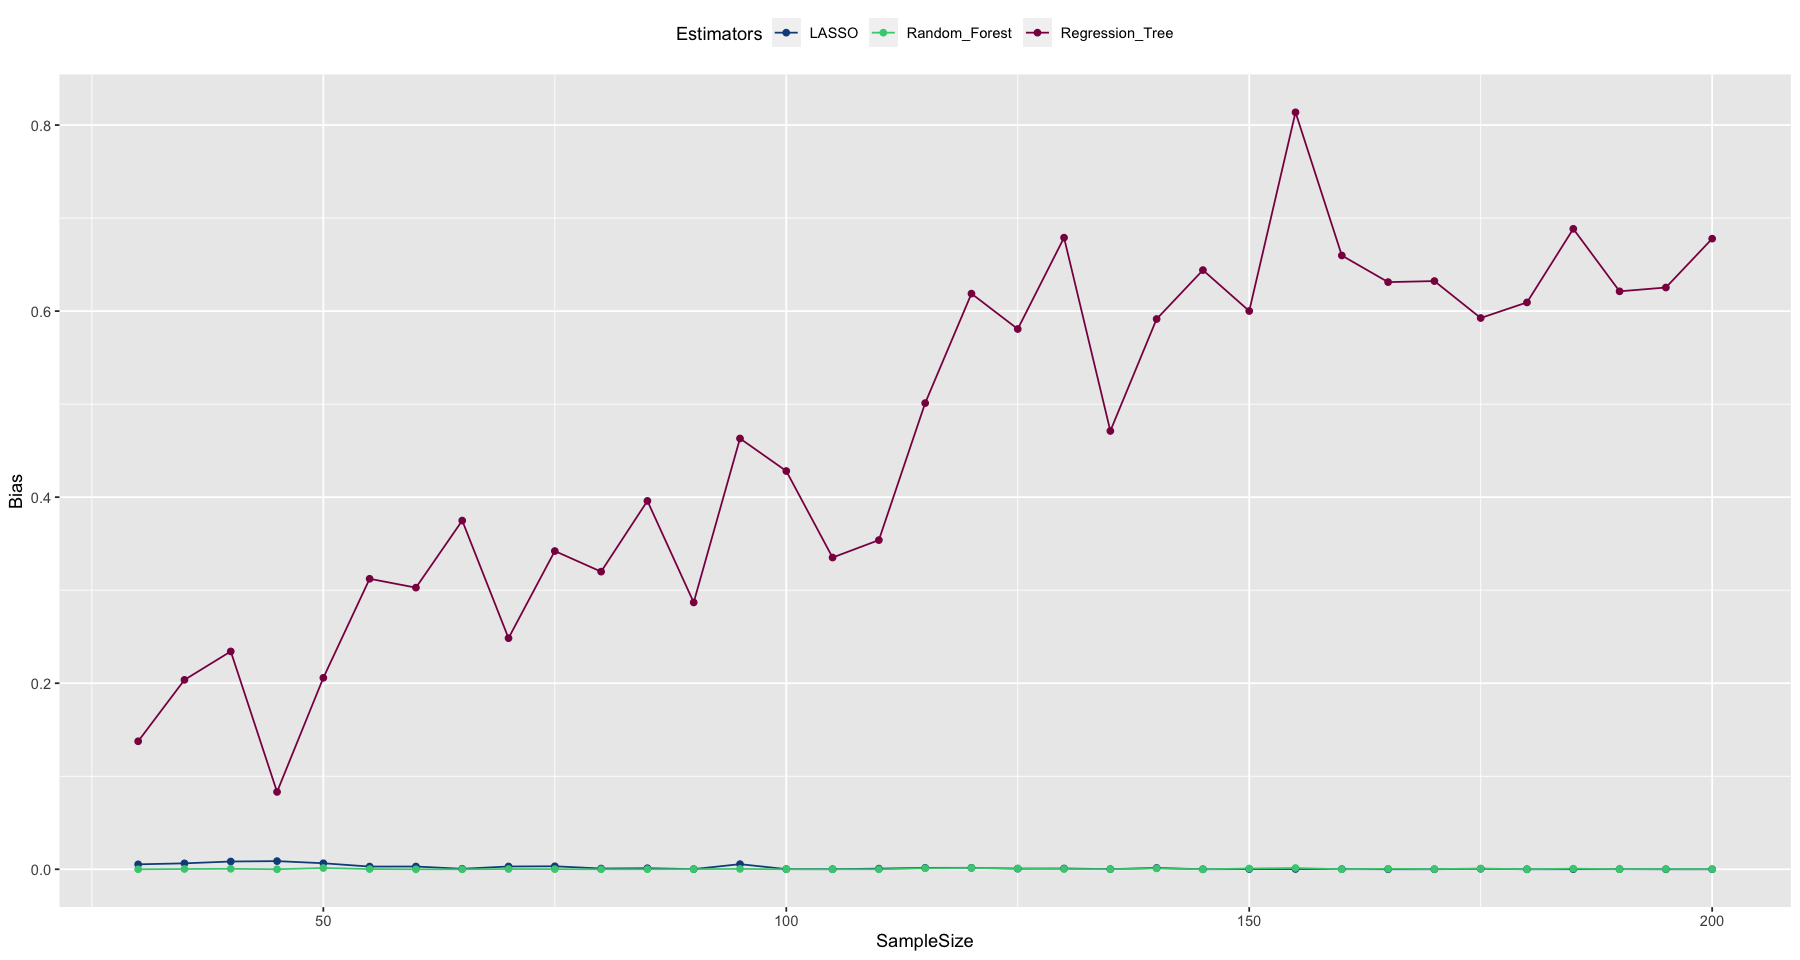

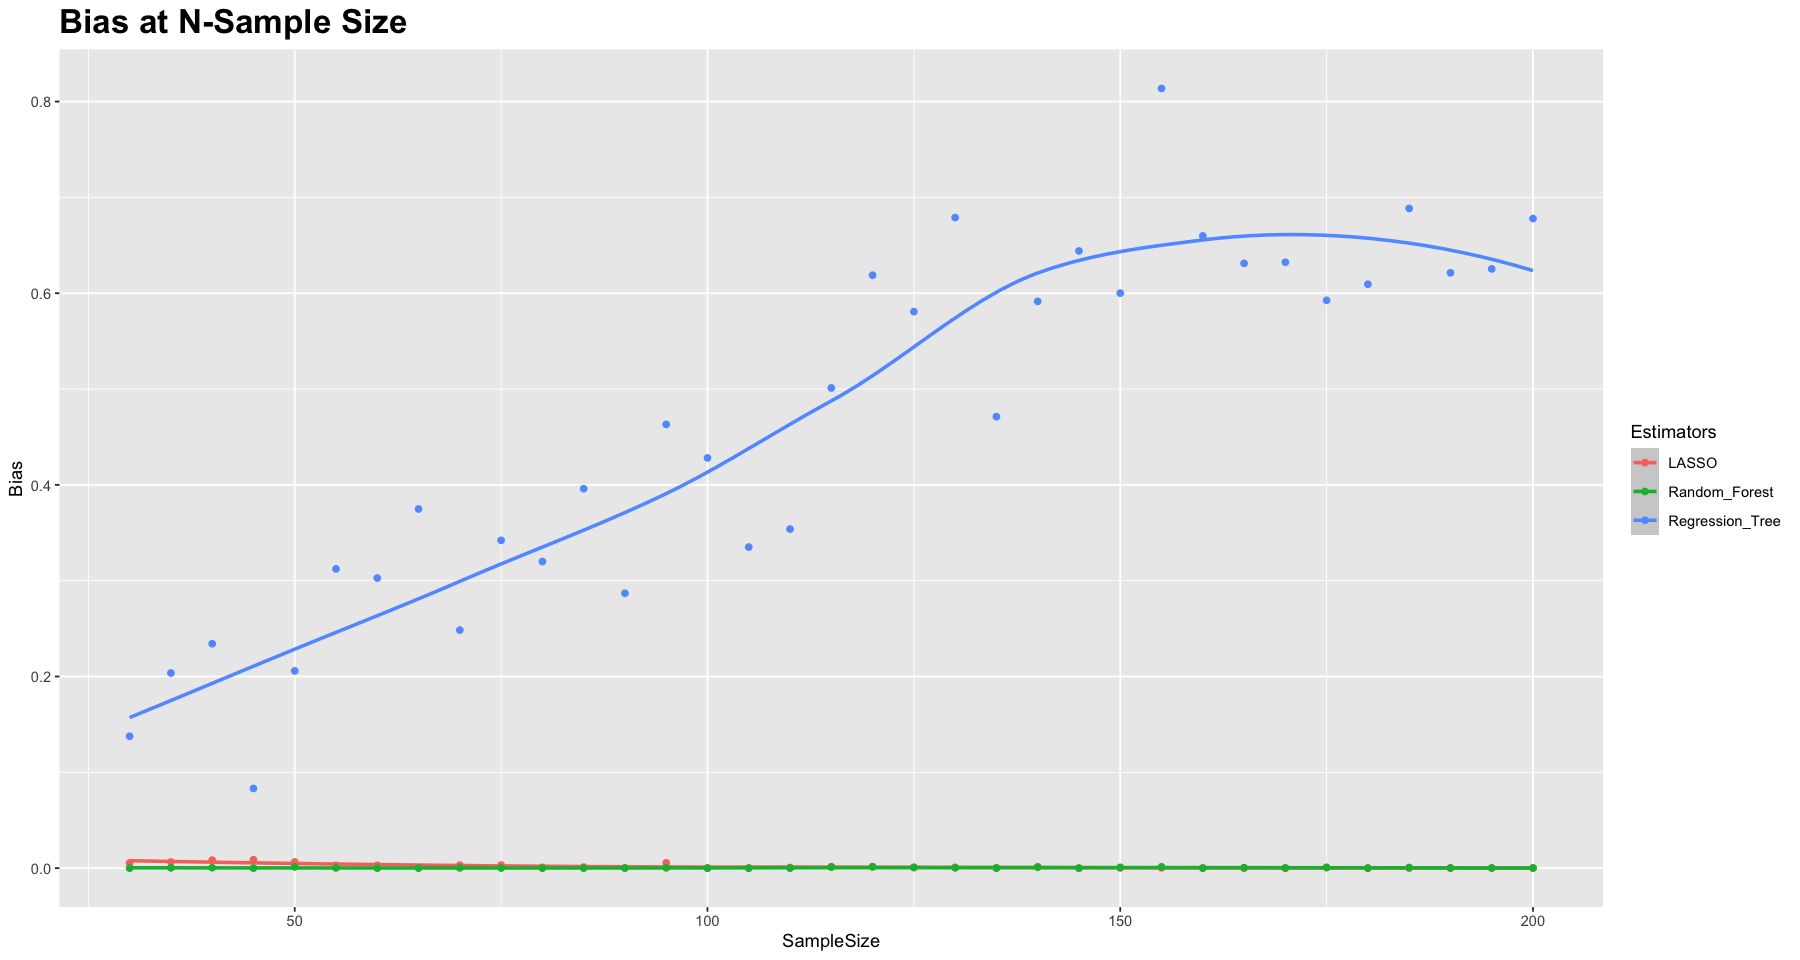

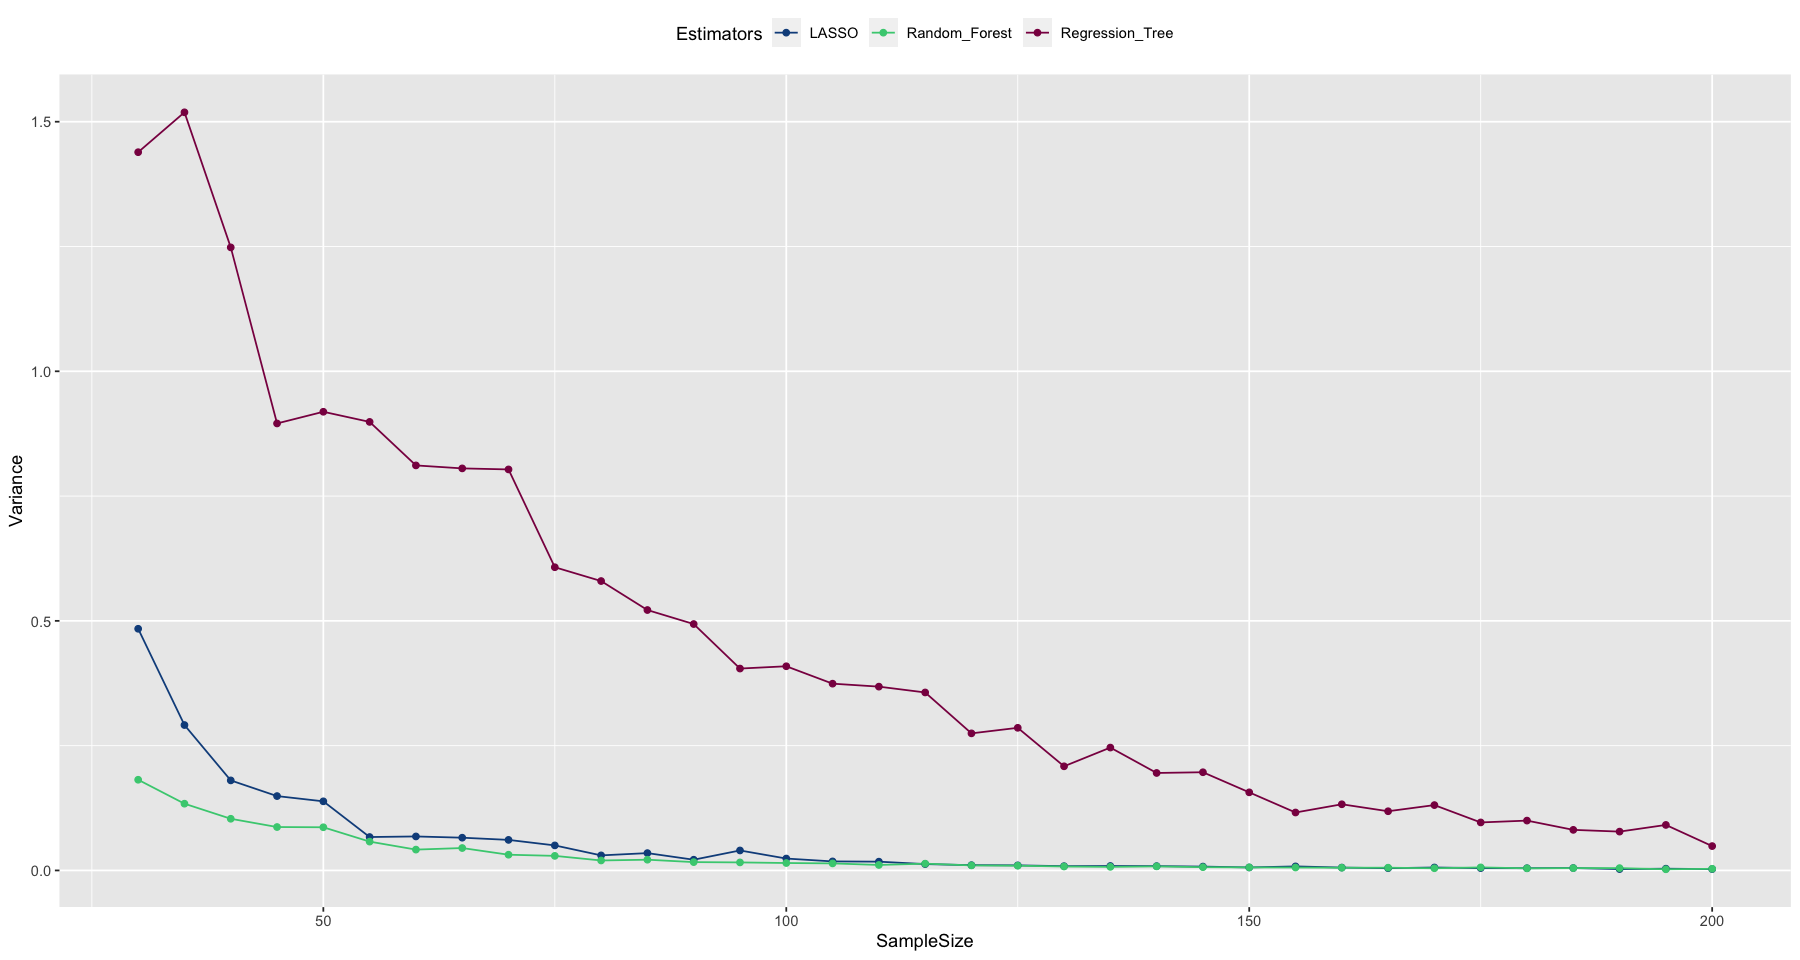

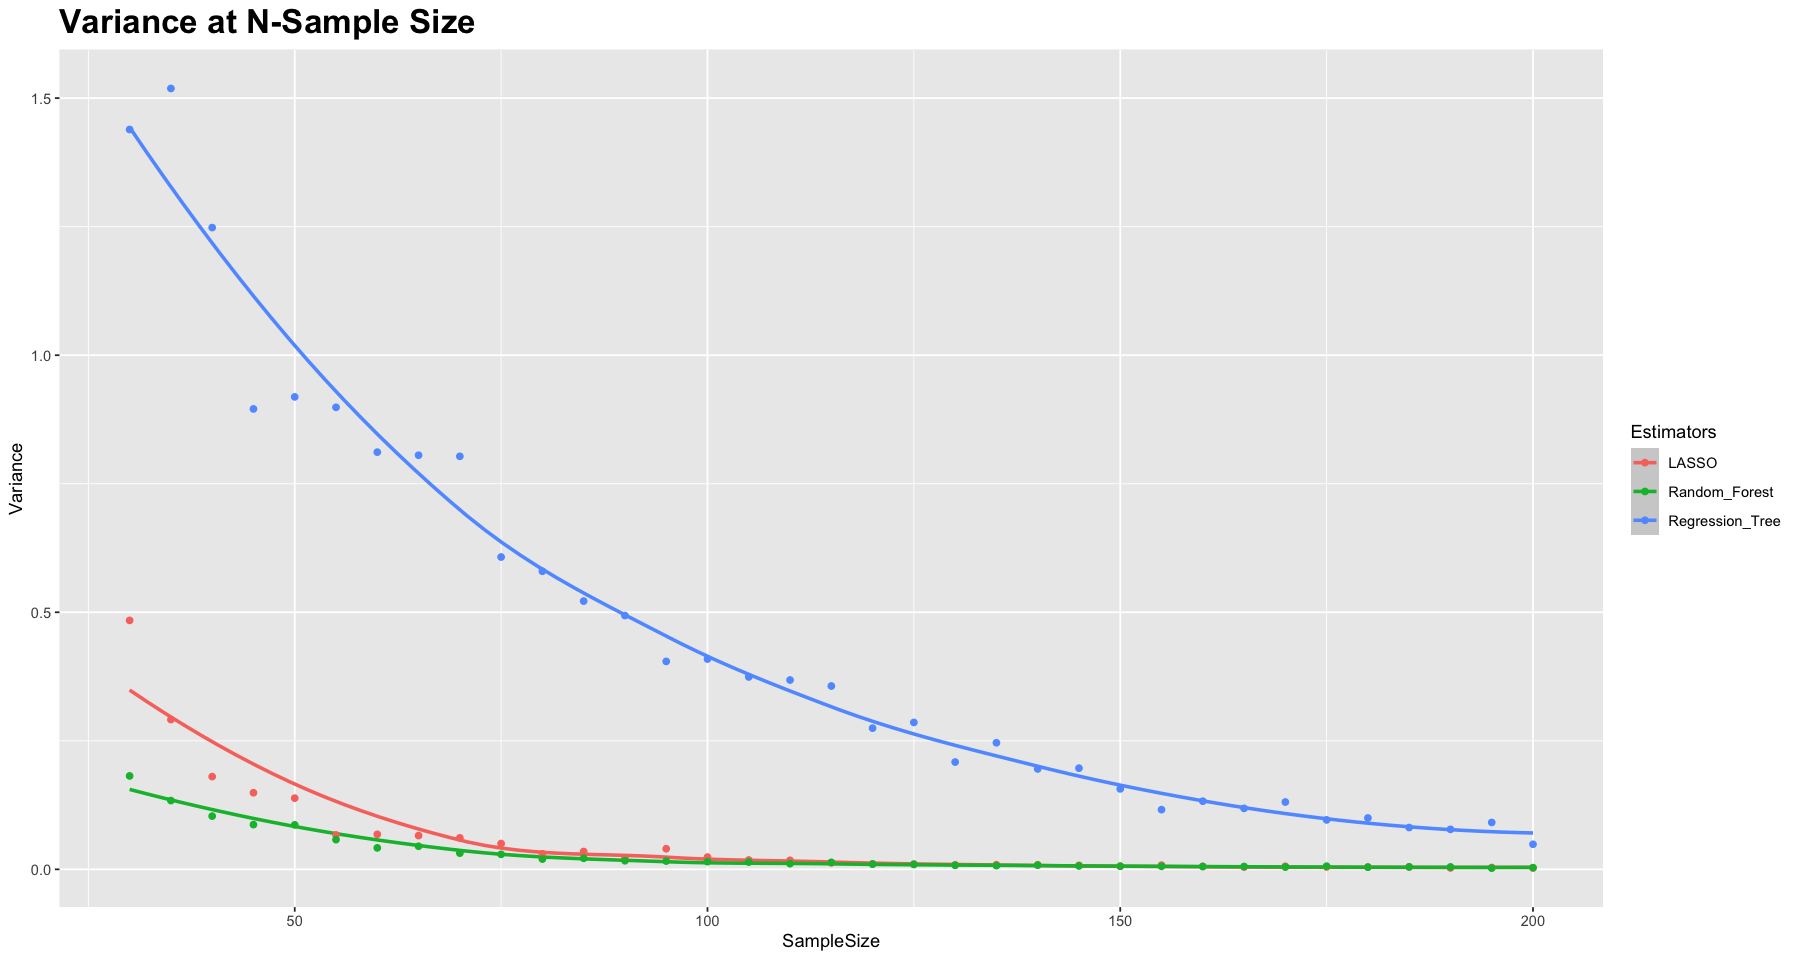

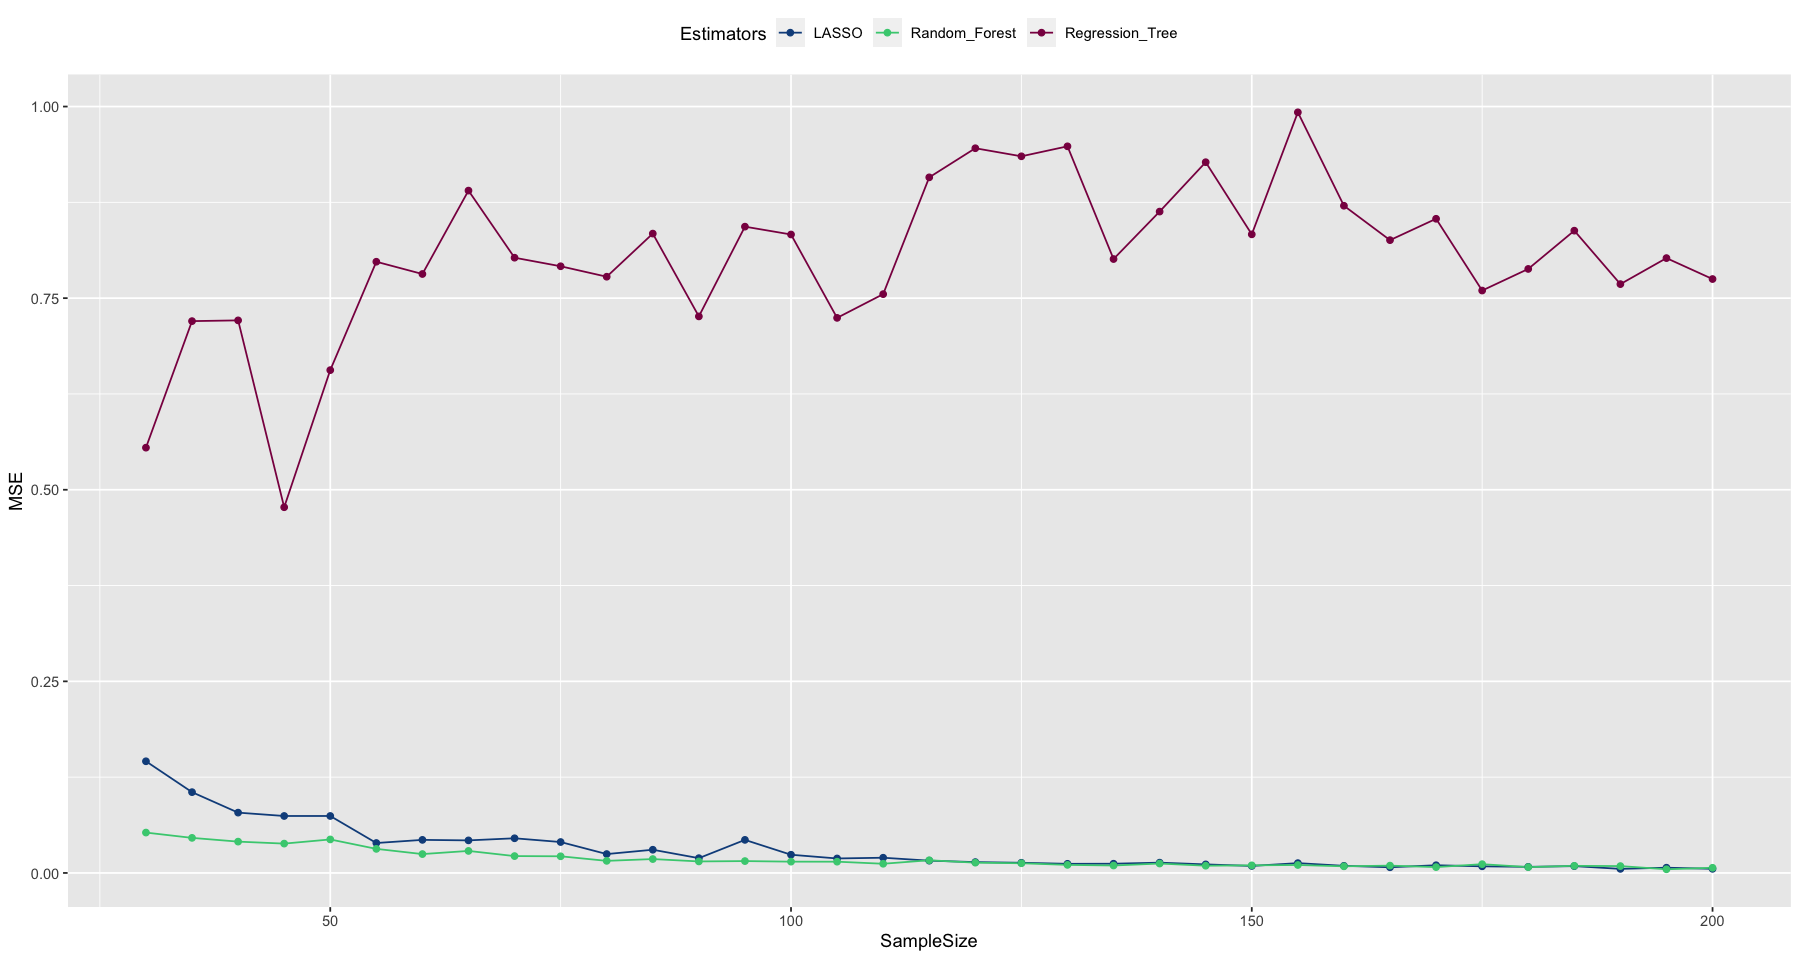

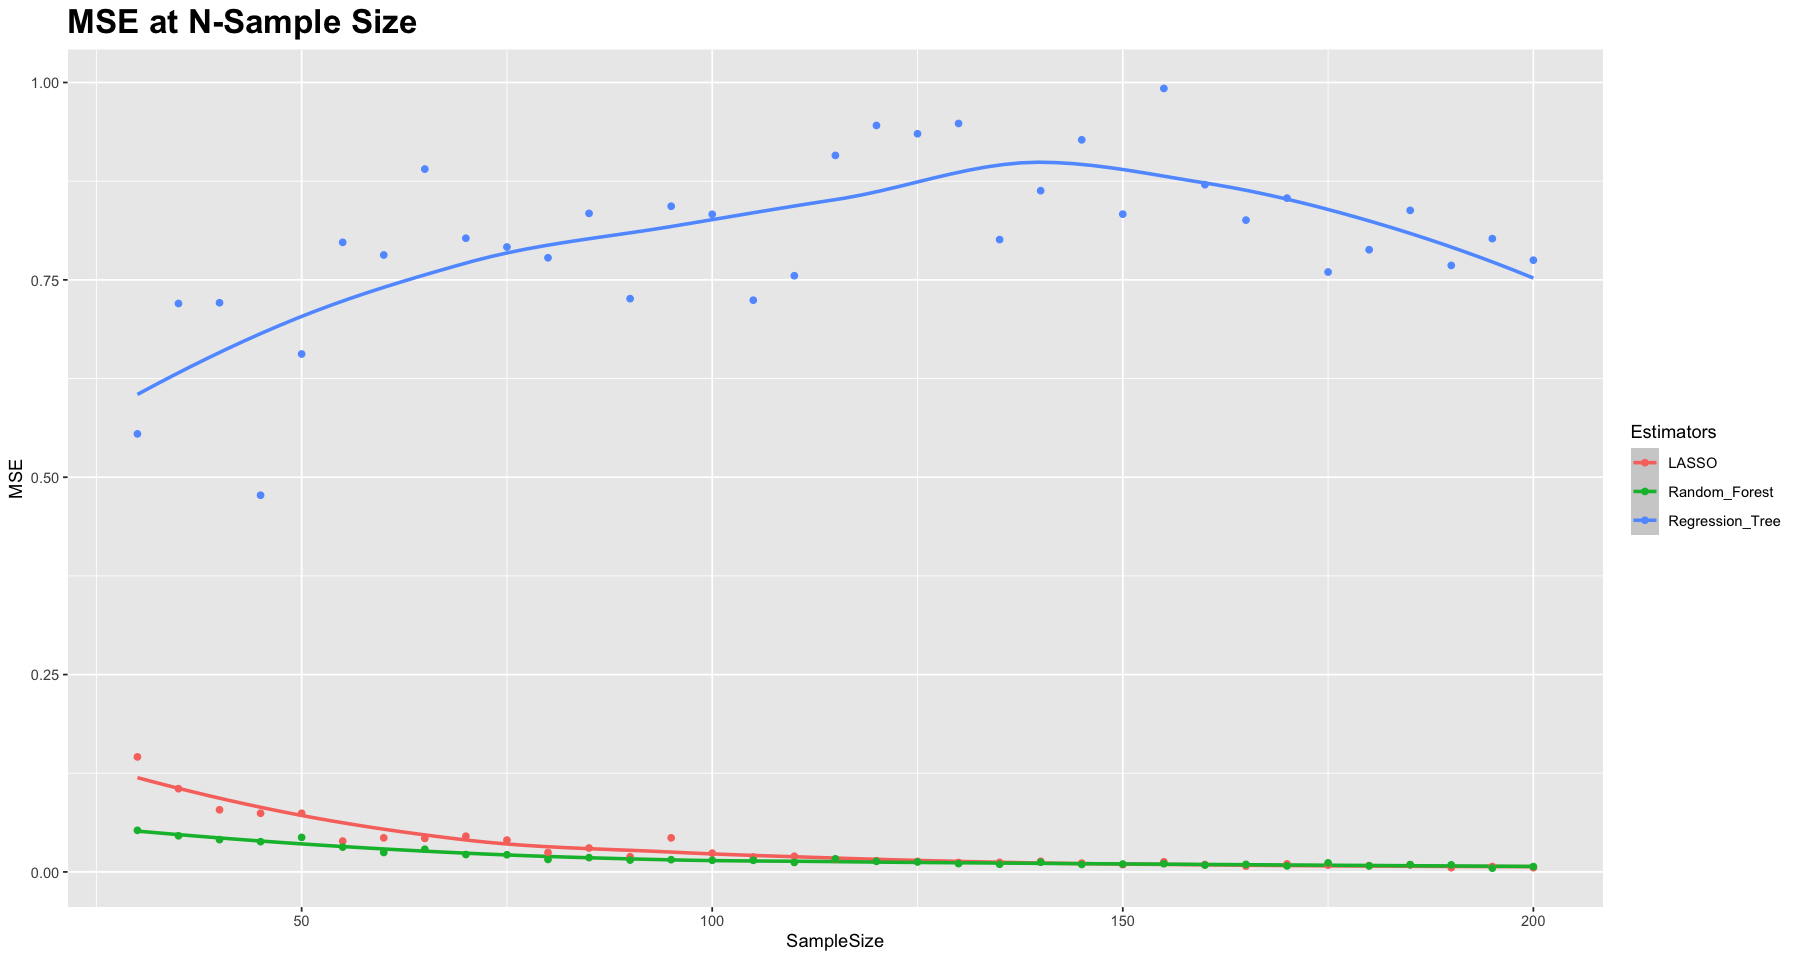

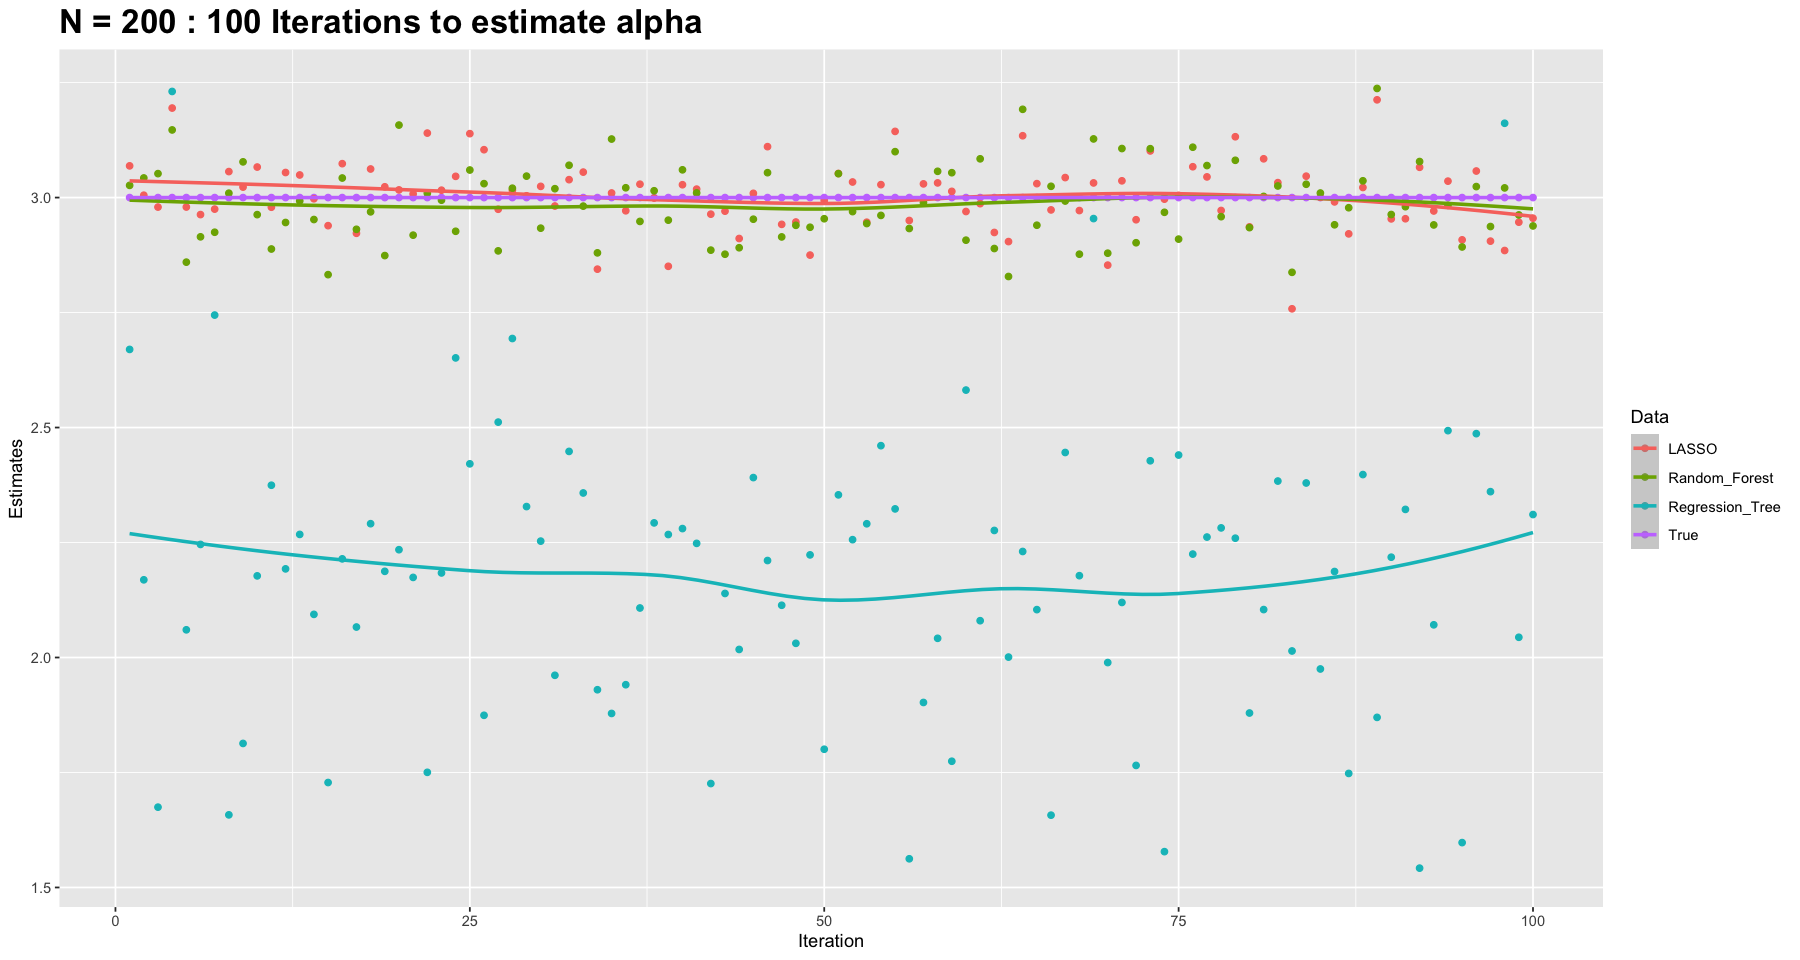

Warning message:
“Removed 100 rows containing non-finite values (stat_bin).”


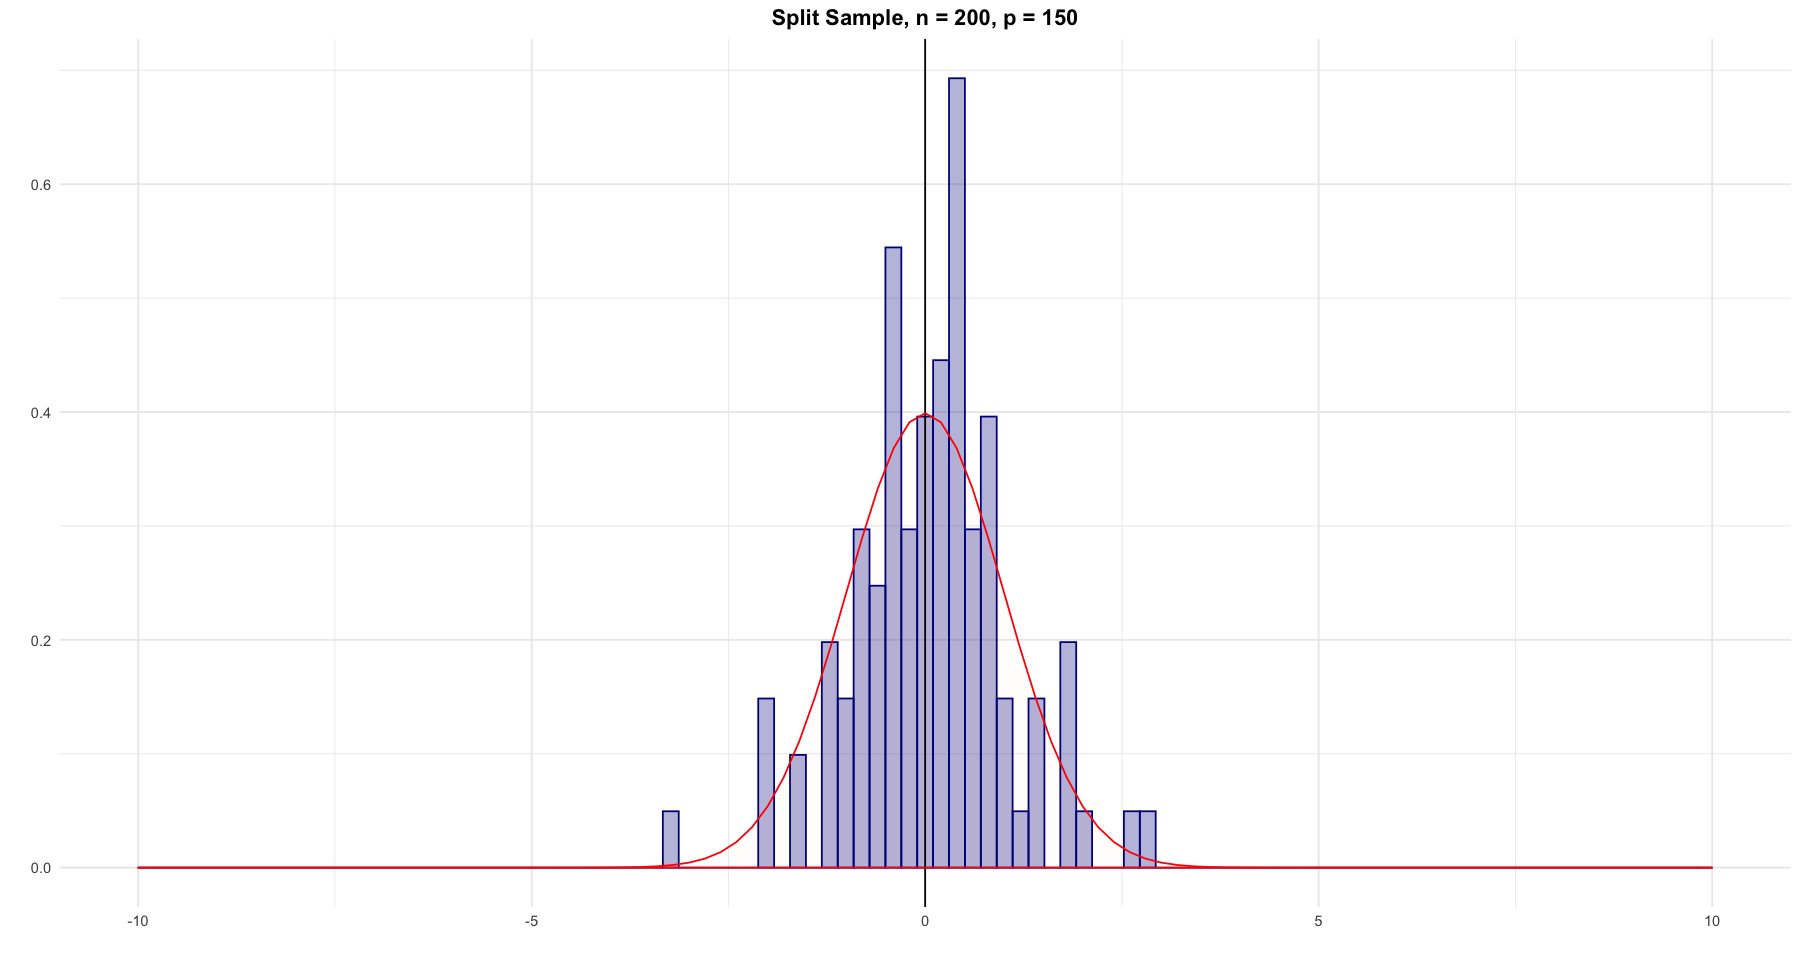

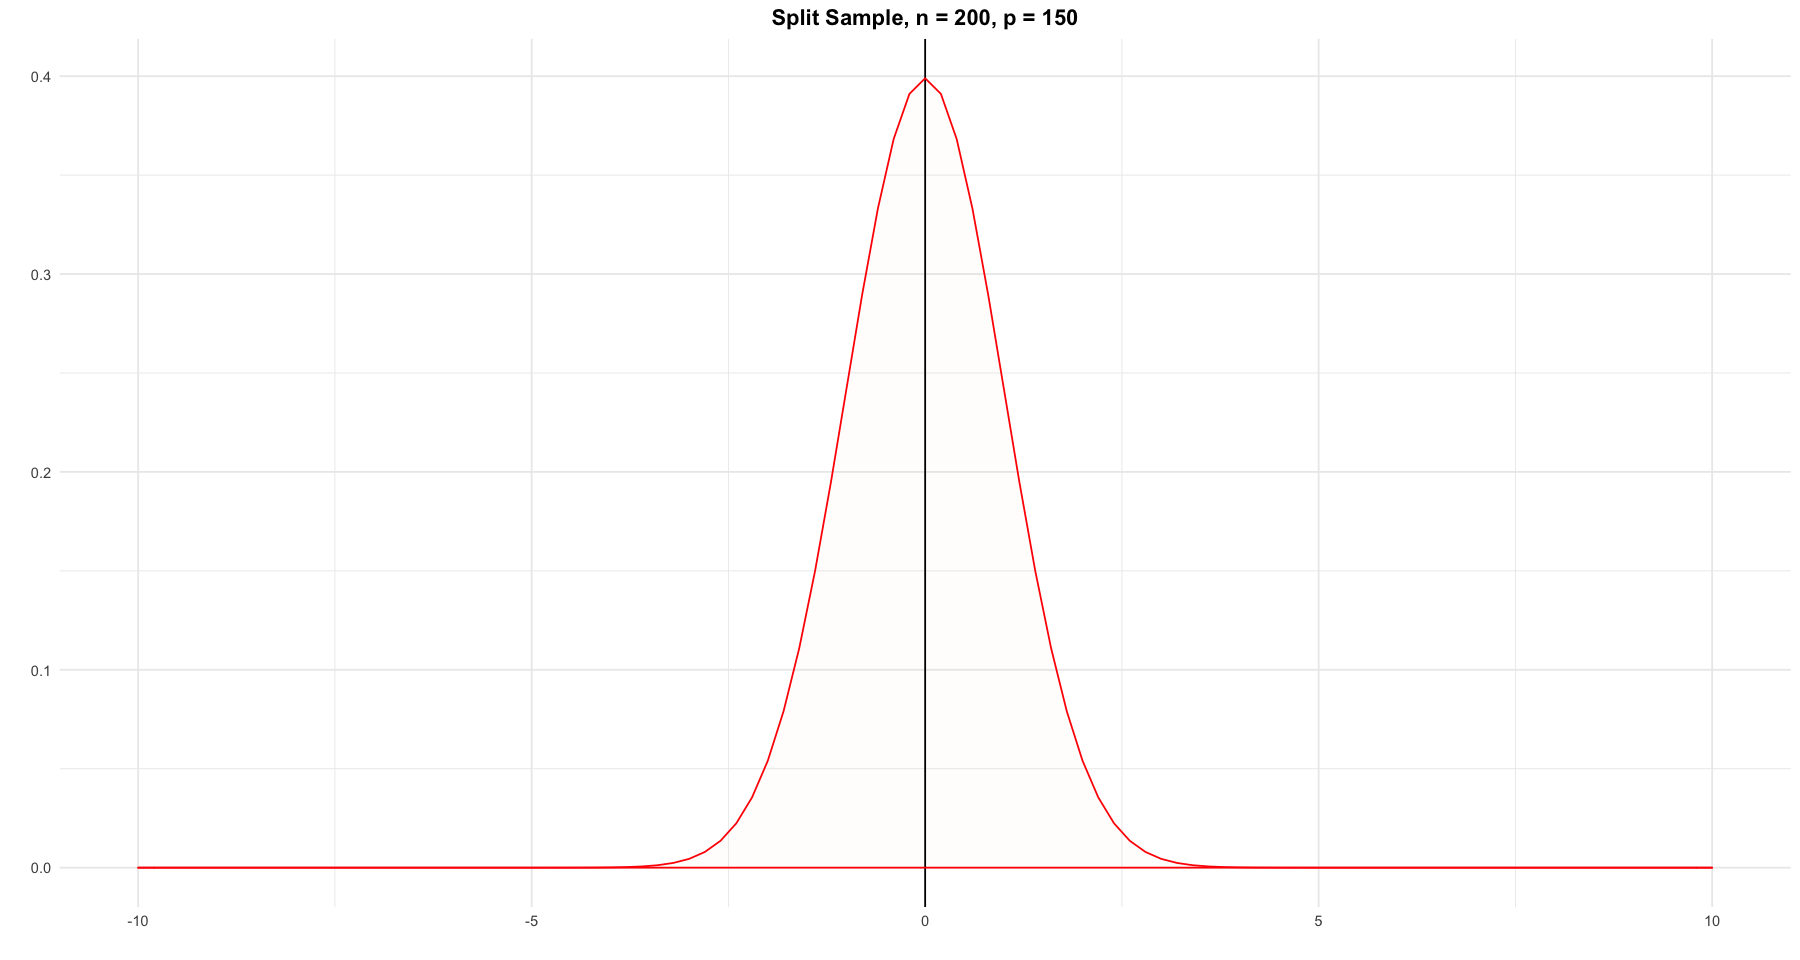

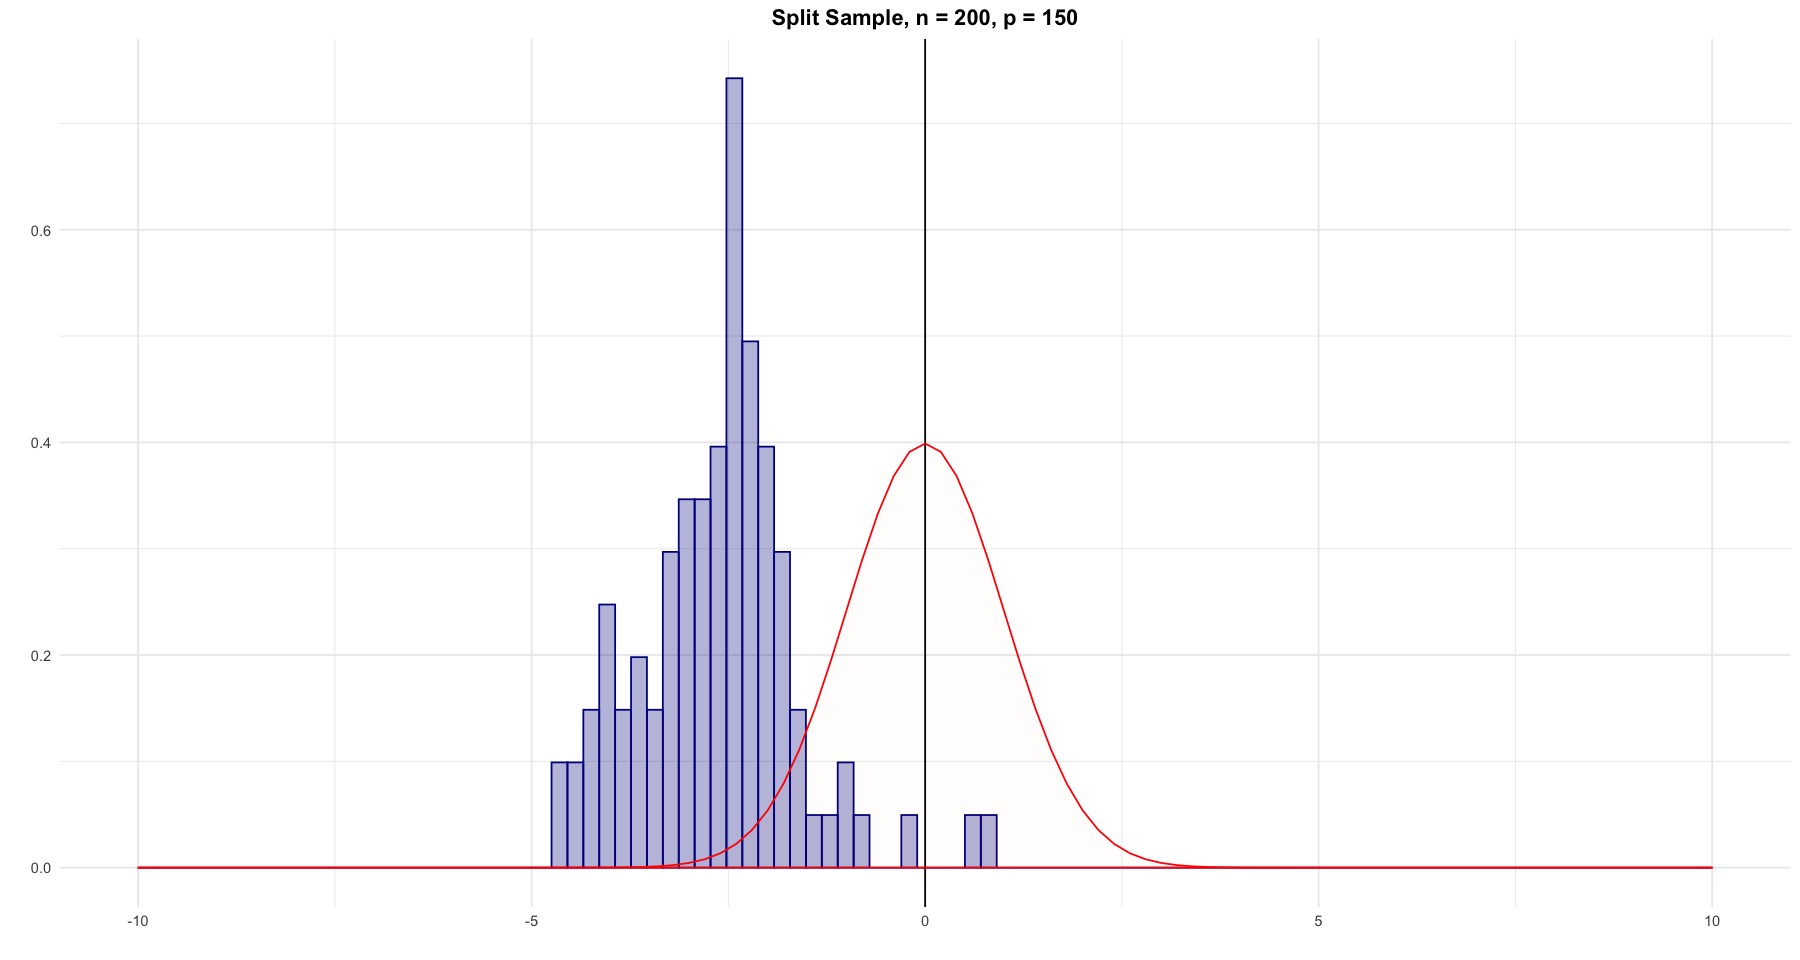

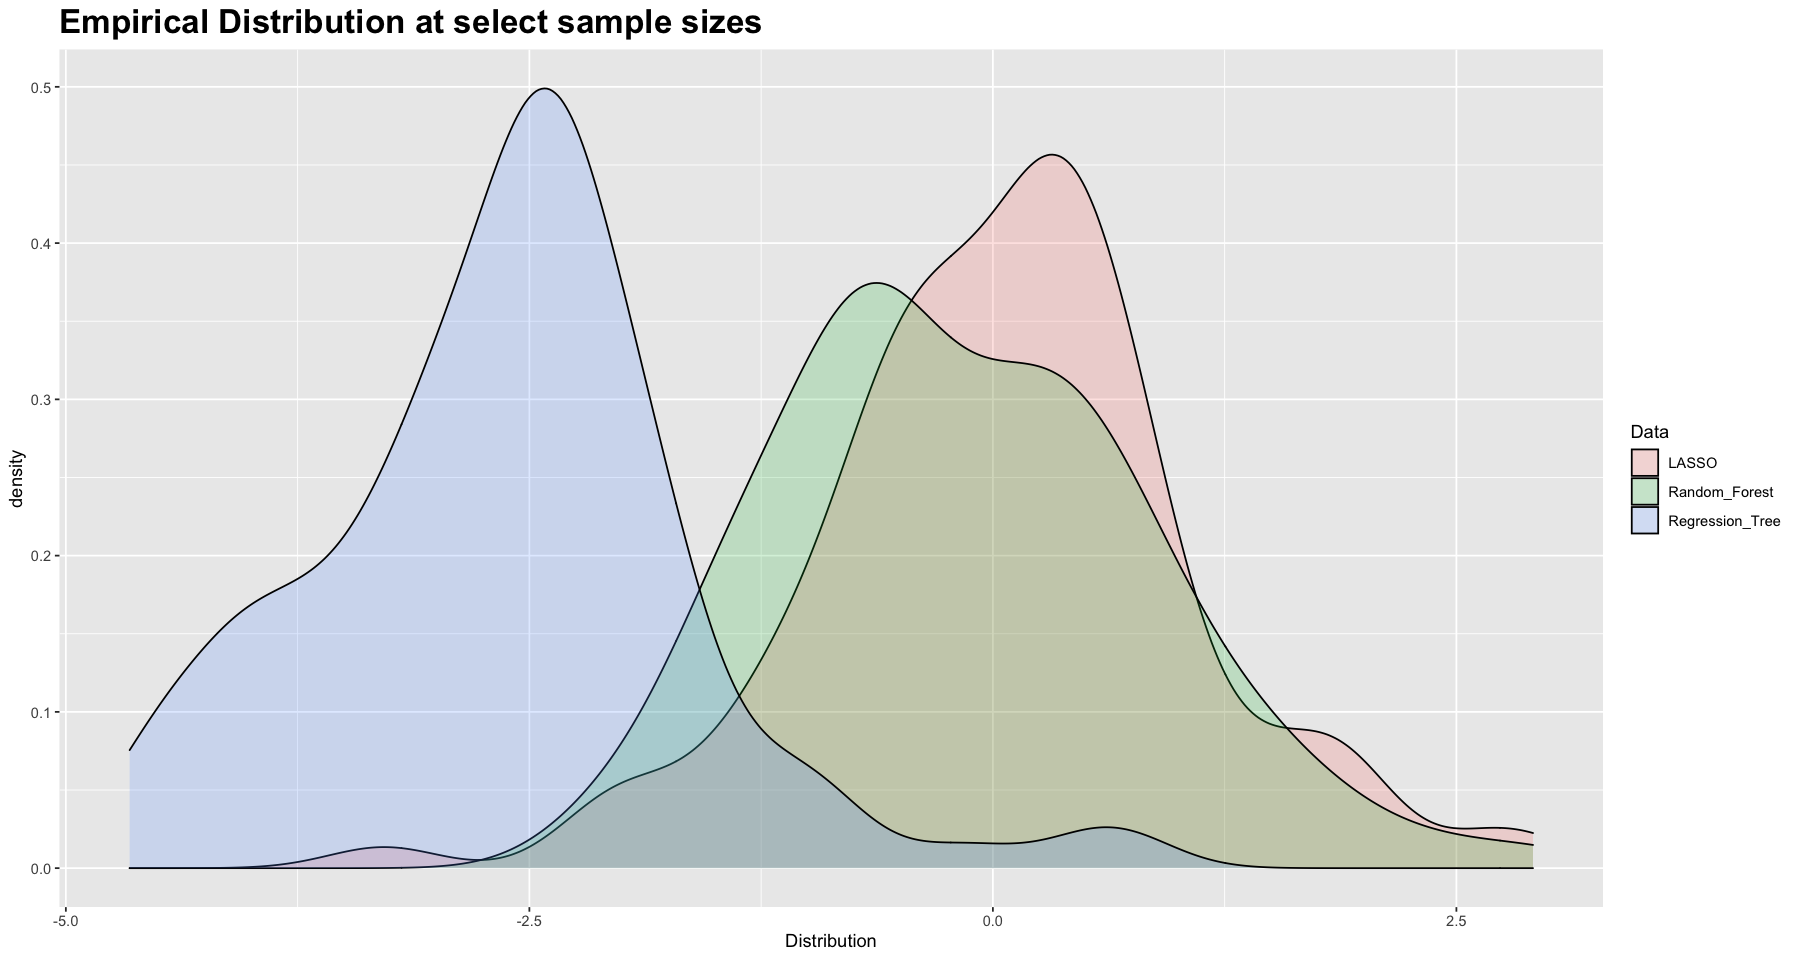

In [9]:
# All the result are organized in a trade-off matrix which will be used to plot graphs
mx_ <- matrix(NA, ncol=3, nrow=n_rep)
mx_[,1] <- (matrix_[,1] - alpha)/(sd(matrix_[,1] - alpha))
mx_[,2] <- (matrix_[,2] - alpha)/(sd(matrix_[,2] - alpha))
mx_[,3] <- (matrix_[,3] - alpha)/(sd(matrix_[,3] - alpha))

n_obs <- sample_size[sim]
theta_dml1 = (matrix_[,1] - alpha)
theta_dml2 = (matrix_[,2] - alpha)
theta_dml3 = (matrix_[,3] - alpha)
df_dml1 = data.frame(theta_dml1)
df_dml2 = data.frame(theta_dml2)
df_dml3 = data.frame(theta_dml3)
sd_dml1 = sd(theta_dml1)
sd_dml2 = sd(theta_dml2)
sd_dml3 = sd(theta_dml3)

df_tradeoff <- data.frame(Estimators = c(rep("LASSO",sim), rep("Random_Forest",sim), rep("Regression_Tree",sim)),
                          Bias       = c(bias_matrix[,1],bias_matrix[,2],bias_matrix[,3]),
                          Variance   = c(var_matrix[,1],var_matrix[,2],var_matrix[,3]),
                          MSE        = c(mse_matrix[,1],mse_matrix[,2],mse_matrix[,3]),
                          SampleSize = rep(sample_size,3))

df_estimates <- data.frame(Data      = c(rep("True",n_rep), rep("LASSO",n_rep), rep("Random_Forest",n_rep), rep("Regression_Tree",n_rep)),
                           Iteration = rep(1:n_rep,4),
                           Estimates = c(rep(alpha, n_rep), matrix_[,1],matrix_[,2],matrix_[,3]))

df_density <- data.frame(Data         = c(rep("LASSO",n_rep), rep("Random_Forest", n_rep),rep("Regression_Tree",n_rep)),
                         Distribution = c(mx_[,1],mx_[,2],mx_[,3]))

df_dml_resc1 = data.frame("theta_dml1" = df_dml1$theta_dml1/sd_dml1)
df_dml_resc2 = data.frame("theta_dml2" = (df_dml2$theta_dml2 - alpha)/sd_dml2)
df_dml_resc3 = data.frame("theta_dml3" = df_dml3$theta_dml3/sd_dml3)


# Plot the Bias against Sample Sizes
ggplot(df_tradeoff, aes(x=SampleSize, y=Bias, group=Estimators)) +
  geom_line(aes(linetype=Estimators, color=Estimators))+
  geom_point(aes(color=Estimators))+
  scale_linetype_manual(values=c("solid","solid","solid"))+
  scale_color_manual(values=c('dodgerblue4','seagreen3','deeppink4'))+
  theme(legend.position="top")

ggplot(data=df_tradeoff, aes(x=SampleSize, y=Bias, group=Estimators, colour=Estimators)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("Bias at N-Sample Size") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(df_tradeoff, aes(x=SampleSize, y=Variance, group=Estimators)) +
  geom_line(aes(linetype=Estimators, color=Estimators))+
  geom_point(aes(color=Estimators))+
  scale_linetype_manual(values=c("solid","solid","solid"))+
  scale_color_manual(values=c('dodgerblue4','seagreen3','deeppink4'))+
  theme(legend.position="top")

# Plot the Variance against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=Variance, group=Estimators, colour=Estimators)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0, 0.003), xlim=c(30, 300)) +
    ggtitle("Variance at N-Sample Size") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the MSE against Sample Sizes
ggplot(df_tradeoff, aes(x=SampleSize, y=MSE, group=Estimators)) +
  geom_line(aes(linetype=Estimators, color=Estimators))+
  geom_point(aes(color=Estimators))+
  scale_linetype_manual(values=c("solid","solid","solid"))+
  scale_color_manual(values=c('dodgerblue4','seagreen3','deeppink4'))+
  theme(legend.position="top")

# Plot the MSE against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=MSE, group=Estimators, colour=Estimators)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0, 0.003), xlim=c(30, 300)) +
    ggtitle("MSE at N-Sample Size") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

ggplot(data=df_estimates, aes(x=Iteration, y=Estimates, group=Data, colour=Data)) +
    geom_point() +
    #coord_cartesian(ylim=c(0.01,0.3)) +
    #geom_line(stat = "smooth", method = lm, formula = y ~ x, color = "cyan", size = 1, alpha = 100) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    ggtitle("N = 200 : 100 Iterations to estimate alpha") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

ggplot(df_dml_resc1, aes(x = theta_dml1)) +
    geom_histogram(aes(y=..density..), bins = 100, fill = "dark blue", alpha = 0.3, color = "dark blue") +
    geom_vline(aes(xintercept = 0), col = "black") +
    xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() +        
    stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
    ggtitle(paste0("Split Sample, n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))

ggplot(df_dml_resc2, aes(x = theta_dml2)) +
    geom_histogram(aes(y=..density..), bins = 100, fill = "dark blue", alpha = 0.3, color = "dark blue") +
    geom_vline(aes(xintercept = 0), col = "black") +
    xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() +        
    stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
    ggtitle(paste0("Split Sample, n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))

ggplot(df_dml_resc3, aes(x = theta_dml3)) +
    geom_histogram(aes(y=..density..), bins = 100, fill = "dark blue", alpha = 0.3, color = "dark blue") +
    geom_vline(aes(xintercept = 0), col = "black") +
    xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() +        
    stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
    ggtitle(paste0("Split Sample, n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))


# Plot the Density when N = 200
ggplot(data=df_density, aes(x=Distribution, fill=Data)) +
    geom_density(alpha=0.2) +
    #coord_cartesian(xlim=c(-0.5, 1)) +
    ggtitle("Empirical Distribution at select sample sizes") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)


In [ ]:
make_plr_CCDDHNR2018 = function(n_obs = 500, dim_x = 20, alpha = 0.5,
  return_type = "DoubleMLData") {

  assert_choice(
    return_type,
    c("data.table", "matrix", "data.frame", "DoubleMLData"))
  cov_mat = toeplitz(0.7^(0:(dim_x - 1)))
  a_0 = 1
  a_1 = 0.25
  s_1 = 1
  b_0 = 1
  b_1 = 0.25
  s_2 = 1
  x = rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat)

  d = as.matrix(a_0 * x[, 1] + a_1 * (exp(x[, 3]) /
    (1 + exp(x[, 3]))) + s_1 * rnorm(n_obs))
  y = as.matrix(alpha * d + b_0 * exp(x[, 1]) /
    (1 + exp(x[, 1])) + b_1 * x[, 3] + s_2 * rnorm(n_obs))

  colnames(x) = paste0("X", 1:dim_x)
  colnames(y) = "y"
  colnames(d) = "d"
  if (return_type == "matrix") {
    return(list("X" = x, "y" = y, "d" = d))
  } else if (return_type == "data.frame") {
    data = data.frame(x, y, d)
    return(data)
  } else if (return_type == "data.table") {
    data = data.table(x, y, d)
    return(data)
  } else if (return_type == "DoubleMLData") {
    dt = data.table(x, y, d)
    data = DoubleMLData$new(dt, y_col = "y", d_cols = "d")
    return(data)
  }
}